# Import Modules

In [1]:
!pip install utils

In [2]:
!pip install livelossplot

In [3]:
# !pip uninstall llvmlite
# !pip install setuptools<60.0
# !pip install numba==0.51
# !pip install daal==2021.4.0

In [4]:
# !pip install tensorflow==2.12.0
#!pip install tensorflow-gpu

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG,Image
#from livelossplot import PlotLossesTensorFlowKeras
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.12.0


In [6]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# print("GPU available:", tf.test.is_gpu_available())
# print("GPU device name:", tf.test.gpu_device_name())

# Load and Explore the Dataset

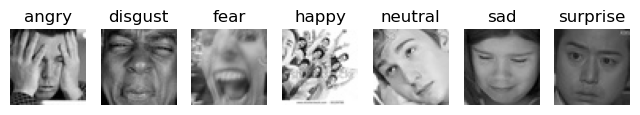

In [7]:
i=1
plt.figure(figsize=(8,8))
for expression in os.listdir('./images/validation/'):
    img=load_img(('./images/validation/'+expression+'/'+os.listdir('./images/validation/'+expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i+=1

plt.show()

In [8]:
#check the amount of data in each folder in training dataset
for expression in os.listdir('./images/train/'):
    print(expression,"folder contains\t\t",len(os.listdir('./images/train/'+expression)),"images")

angry folder contains		 3993 images
disgust folder contains		 436 images
fear folder contains		 4103 images
happy folder contains		 7164 images
neutral folder contains		 4982 images
sad folder contains		 4938 images
surprise folder contains		 3205 images


In [9]:
#check the amount of data in each folder in testing dataset
for expression in os.listdir('./images/validation/'):
    print(expression,"folder contains\t\t",len(os.listdir('./images/validation/'+expression)),"images")

angry folder contains		 960 images
disgust folder contains		 111 images
fear folder contains		 1018 images
happy folder contains		 1825 images
neutral folder contains		 1216 images
sad folder contains		 1139 images
surprise folder contains		 797 images


# Augmentation and Preprocessing

In [10]:
#Data Augmentation
datagen_train=ImageDataGenerator(rescale=1./255,
                                 zoom_range=0.3,
                                 horizontal_flip=True)

train_generator=datagen_train.flow_from_directory('./images/train/',
                                                 batch_size=64,
                                                 target_size=(48,48),
                                                 shuffle=True,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

datagen_test=ImageDataGenerator(rescale=1./255,
                                 zoom_range=0.3,
                                 horizontal_flip=True)

test_generator=datagen_test.flow_from_directory('./images/validation/',
                                                 batch_size=64,
                                                 target_size=(48,48),
                                                 shuffle=True,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Build the CNN model

In [11]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       2

# Training and Saving the model

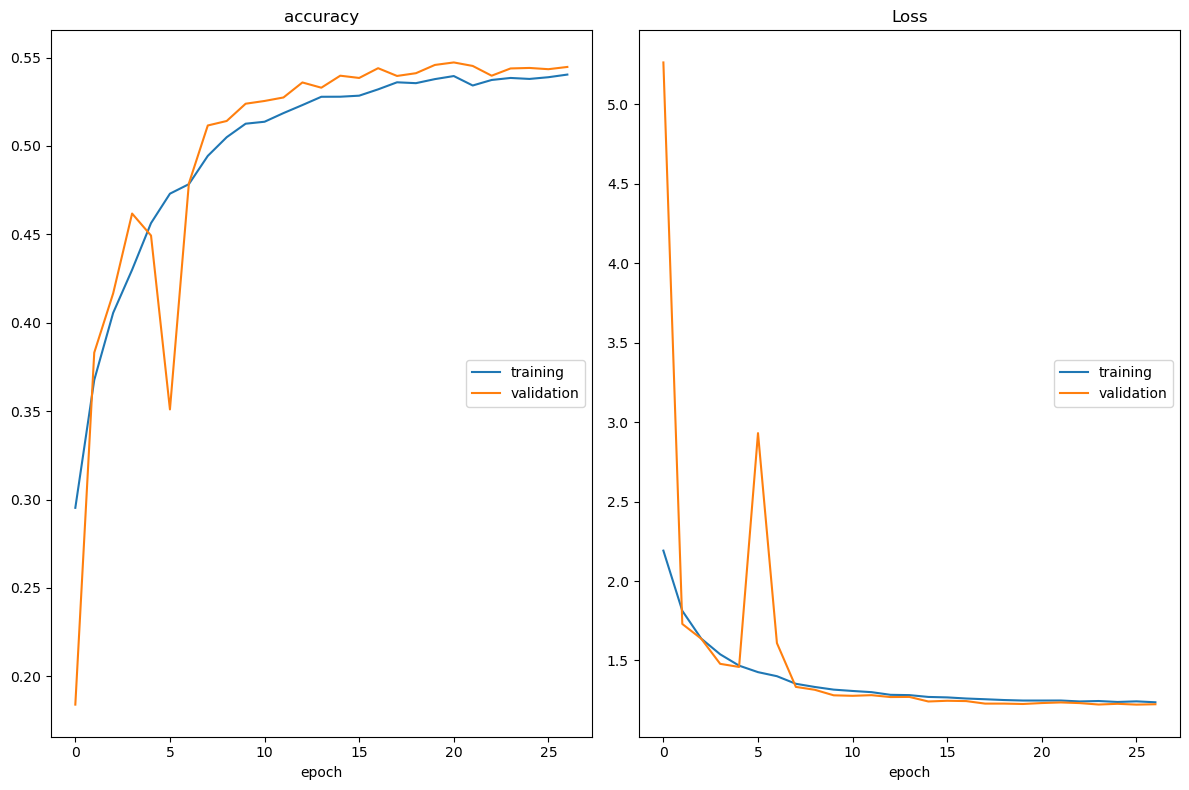

accuracy
	training         	 (min:    0.295, max:    0.540, cur:    0.540)
	validation       	 (min:    0.184, max:    0.547, cur:    0.545)
Loss
	training         	 (min:    1.237, max:    2.191, cur:    1.237)
	validation       	 (min:    1.222, max:    5.264, cur:    1.224)

Epoch 27: saving model to model_weights.h5
450/450 [==============================] - 47s 104ms/step - loss: 1.2368 - accuracy: 0.5404 - val_loss: 1.2244 - val_accuracy: 0.5447 - lr: 1.0000e-05


In [12]:
epochs=27
steps_per_epoch=train_generator.n/train_generator.batch_size
testing_steps=test_generator.n/test_generator.batch_size

checkpoint=ModelCheckpoint("model_weights.h5",monitor="val_accuracy",save_weights_only=True,mode='max',verbose=1)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks=[PlotLossesCallback(),checkpoint,reduce_lr]

history=model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=testing_steps,
    callbacks=callbacks
)

# Evaluation

**Training and validation loss curves**

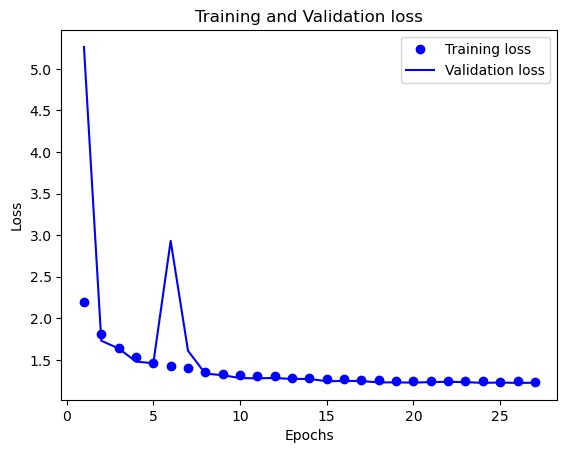

In [13]:
#plot the train and validation loss
train_loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(train_loss)+1)
plt.plot(epochs,train_loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Training and Validation accuracy curves**

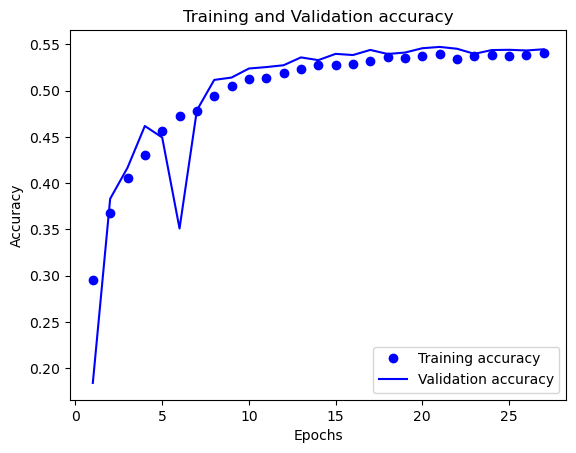

In [14]:
#plot the train and validation accuracy
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(epochs,train_acc,'bo',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix

111/111 [==============================] - 4s 34ms/step


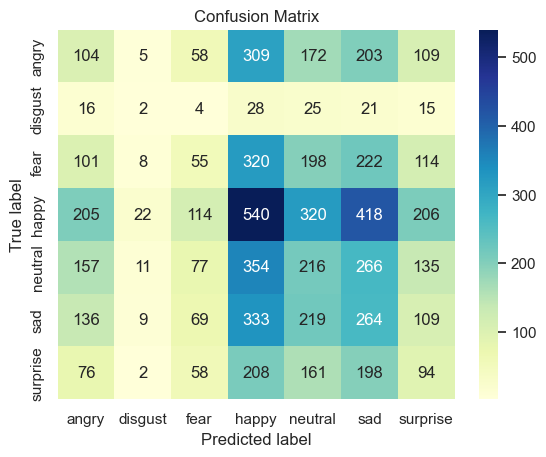

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Get the true labels and predicted labels for the validation set
validation_labels=test_generator.classes
validation_pred_probs=model.predict(test_generator)
validation_pred_labels=np.argmax(validation_pred_probs,axis=1)

#compute the confusion matrix
cm=confusion_matrix(validation_labels,validation_pred_labels)
class_names=list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(cm,annot=True,fmt='d',cmap='YlGnBu',
            xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
label_dict={0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [17]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
def prediction(url):
    img=plt.imread(url)
    plt.imshow(img)
    data=img_to_array(img)
    data=data/255
    data=tf.image.resize(data,(48,48))
    samples=np.expand_dims(data,0)
    samples=np.resize(samples,(1,48,48,1))
    result=model.predict(samples)
    result=list(result[0])
    print(result)
    predictions=label_dict[np.argmax(result)]
    return predictions

1/1 [==============================] - 0s 63ms/step
[0.4863798, 0.004408371, 0.13056128, 0.0034706467, 0.26311213, 0.08848312, 0.023584668]


'Angry'

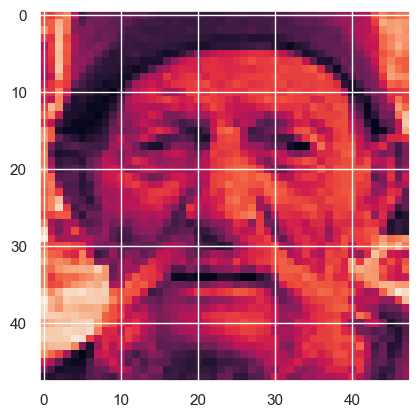

In [18]:
prediction('./images/validation/neutral/10346.jpg')

1/1 [==============================] - 0s 14ms/step
[0.08463237, 0.00014141602, 0.07957124, 0.019962044, 0.6190152, 0.19427249, 0.0024051971]


'Neutral'

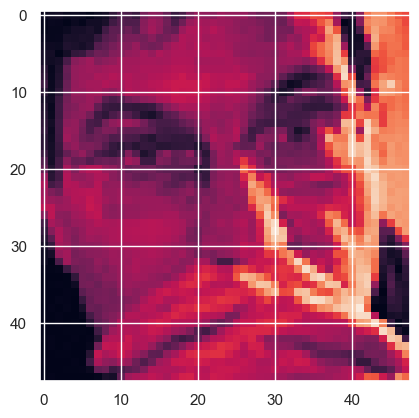

In [19]:
prediction('./images/validation/fear/10099.jpg')

1/1 [==============================] - 0s 14ms/step
[0.4714685, 0.008164094, 0.08728913, 0.0017134403, 0.23125665, 0.19839619, 0.0017120094]


'Angry'

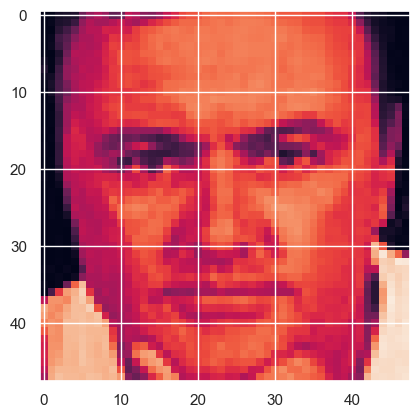

In [20]:
prediction('./images/validation/fear/10292.jpg')

we need some progress to overcome the overfitting

In [21]:
from keras.models import Sequential,load_model

In [22]:
model2 = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 128)       

In [23]:
import keras
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5)
learning_rate_reduction=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=4,verbose=2,factor=0.25,min_lr=0.00001)
checkpoint=ModelCheckpoint("Model2.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [24]:
model2.compile(
       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
       loss='categorical_crossentropy',
       metrics=['accuracy'])

In [25]:
history=model2.fit(train_generator,
                  validation_data=test_generator,verbose=1,epochs=20,
                  callbacks=[early_stopping,learning_rate_reduction,checkpoint])

Epoch 1/20
451/451 [==============================] - ETA: 0s - loss: 1.8193 - accuracy: 0.2461
Epoch 1: val_accuracy improved from -inf to 0.28290, saving model to Model2.h5
451/451 [==============================] - 38s 83ms/step - loss: 1.8193 - accuracy: 0.2461 - val_loss: 1.7538 - val_accuracy: 0.2829 - lr: 1.0000e-04
Epoch 2/20
451/451 [==============================] - ETA: 0s - loss: 1.7285 - accuracy: 0.3045
Epoch 2: val_accuracy improved from 0.28290 to 0.35947, saving model to Model2.h5
451/451 [==============================] - 37s 83ms/step - loss: 1.7285 - accuracy: 0.3045 - val_loss: 1.6557 - val_accuracy: 0.3595 - lr: 1.0000e-04
Epoch 3/20
451/451 [==============================] - ETA: 0s - loss: 1.6607 - accuracy: 0.3468
Epoch 3: val_accuracy improved from 0.35947 to 0.37320, saving model to Model2.h5
451/451 [==============================] - 37s 82ms/step - loss: 1.6607 - accuracy: 0.3468 - val_loss: 1.6112 - val_accuracy: 0.3732 - lr: 1.0000e-04
Epoch 4/20
451/451 

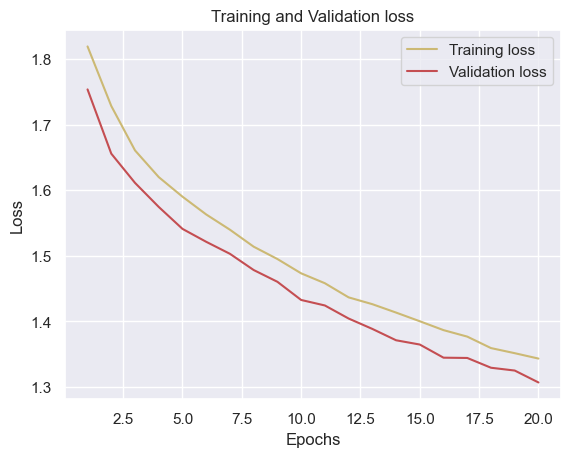

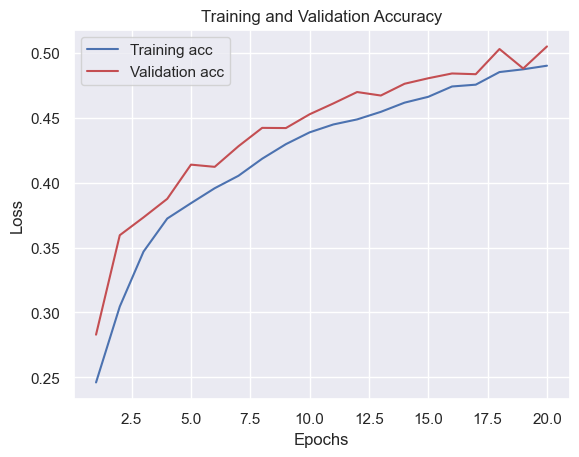

In [26]:
#plot the training and validation accuracy and loss at each epoch
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(epochs,acc,label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
our_model=load_model('Model2.h5')

In [28]:
train_loss,train_acc=our_model.evaluate(train_generator)
test_loss,valid_acc=our_model.evaluate(test_generator)

111/111 [==============================] - 4s 34ms/step - loss: 1.3068 - accuracy: 0.5088


In [29]:
def prediction1(url):
    img=plt.imread(url)
    plt.imshow(img)
    data=img_to_array(img)
    data=data/255
    data=tf.image.resize(data,(48,48))
    samples=np.expand_dims(data,0)
    samples=np.resize(samples,(1,48,48,1))
    result=our_model.predict(samples)
    result=list(result[0])
    print(result)
    predictions=label_dict[np.argmax(result)]
    return predictions

1/1 [==============================] - 0s 49ms/step
[0.025352096, 0.0019281842, 0.17572822, 0.0955282, 0.007637248, 0.006717398, 0.6871086]


'Surprise'

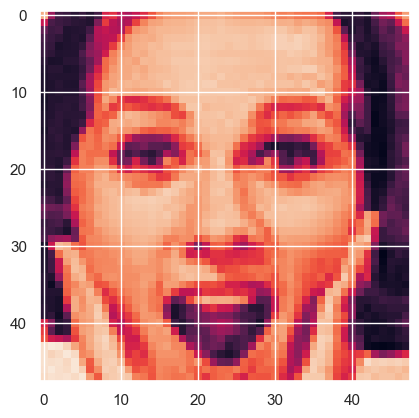

In [30]:
prediction1('./images/train/surprise/10011.jpg')

1/1 [==============================] - 0s 13ms/step
[0.21215487, 0.016021889, 0.11493406, 0.029278792, 0.22343953, 0.39873365, 0.0054371627]


'Sad'

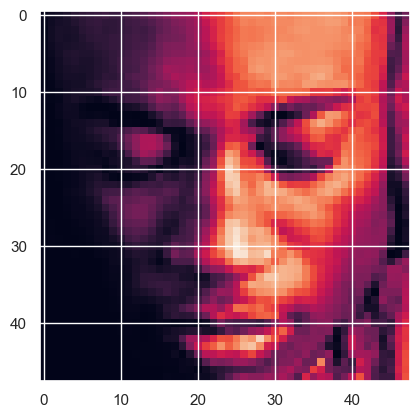

In [31]:
prediction1('./images/validation/sad/10339.jpg')

1/1 [==============================] - 0s 14ms/step
[0.21131156, 0.06029205, 0.22026154, 0.09032963, 0.17218716, 0.19255857, 0.053059448]


'Fear'

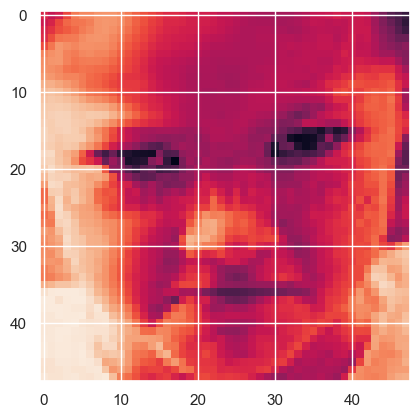

In [32]:
prediction1('./images/validation/angry/1024.jpg')

It's a bit better now

# Recommending a music

In [1]:
# !pip install opencv-python

In [2]:
import pandas as pd
import cv2

In [3]:
mood_music=pd.read_csv('./data_moods.csv')
mood_music=mood_music[['name','artist','mood']]
mood_music.head()

,name,artist,mood
0,1999,Prince,Happy
1,23,Blonde Redhead,Sad
2,9 Crimes,Damien Rice,Sad
3,99 Luftballons,Nena,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic


In [4]:
image=cv2.imread('./images/train/happy/10060.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

NameError: name 'plt' is not defined

In [5]:
image=cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=model2.predict(img)
result=np.argmax(predict_x,axis=1)
result[0]

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
if(result[0]==0 or result[0]==1 or result[0]==2):
    #for angry,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2=f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy,neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2=f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
    #for sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2=f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
    #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2=f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

Hope this additional feature is nice

# 用openCV讀取用戶表情

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def emotion_detection(model, image):
    # 调整图像大小为模型输入大小
    image = cv2.resize(image, (48, 48))

    # 归一化像素值并重新构造数组形状
    image = np.array(image) / 255.0
    image = image.reshape(1, 48, 48, 1)

    # 进行情绪分类预测
    predict_x = model.predict(image)
    emotion_label = np.argmax(predict_x, axis=1)[0]

    # 返回情绪标签
    return emotion_label

In [ ]:
# 加载情绪分类模型（model2）
model2 = tf.keras.models.load_model('model2.h5')

# 加载人脸检测器（haarcascade）
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 打开视频捕获设备
cap = cv2.VideoCapture(0)

i = 0
emotion_label = 0
while True:
    # 读取视频帧
    ret, frame = cap.read()

    # 将帧转换为灰度图像
    if len(frame.shape) > 2:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray = frame

    # 检测人脸
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # 对检测到的每个人脸进行情绪分类
    for (x, y, w, h) in faces:
        # 提取人脸区域
        face_img = gray[y:y+h, x:x+w]

        # 调用情绪检测函数
        if i == 4:
            emotion_label = emotion_detection(model2, face_img)
            i = 0
        i+=1

        # 根据情绪类别绘制边界框和标签
        if emotion_label == 0:
            emotion_text = "Angry"
            color = (0, 0, 255)  # 红色
        elif emotion_label == 1:
            emotion_text = "Disgust"
            color = (0, 255, 0)  # 绿色
        elif emotion_label == 2:
            emotion_text = "Fear"
            color = (255, 0, 0)  # 蓝色
        elif emotion_label == 3:
            emotion_text = "Happy"
            color = (255, 255, 0)  # 黄色
        elif emotion_label == 4:
            emotion_text = "Neutral"
            color = (255, 255, 255)  # 白色
        elif emotion_label == 5:
            emotion_text = "Sad"
            color = (255, 0, 255)  # 紫色
        elif emotion_label == 6:
            emotion_text = "Surprise"
            color = (0, 255, 255)  # 青色

        # 绘制人脸边界框和情绪标签
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, emotion_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        
    # 显示帧
    cv2.imshow('Emotion Detection', frame)

    # 按下 'q' 键退出循环
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 释放资源
cap.release()
cv2.destroyAllWindows()